In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from keras.preprocessing.image import ImageDataGenerator

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import pandas as pd
import skimage.io as io
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.applications.xception import Xception, preprocess_input
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.layers import *
%matplotlib inline

In [3]:
# we create two instances with the same arguments
train_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=45,
                     width_shift_range=10,
                     height_shift_range=10,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=False,
                     fill_mode='nearest')
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

val_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=45,
                     width_shift_range=10,
                     height_shift_range=10,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=False,
                     fill_mode='nearest')
val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_data_gen_args)

In [4]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
batch_size=5
train_image_generator = train_image_datagen.flow_from_directory(
    'data/training/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data/training/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
train_generator = zip(train_image_generator, train_mask_generator)

val_image_generator = val_image_datagen.flow_from_directory(
    'data/validation/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data/validation/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_generator = zip(val_image_generator, val_mask_generator)

Found 7 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 7 images belonging to 1 classes.


In [5]:
train_image_generator.filenames

['skin/ISIC_0000000.jpg',
 'skin/ISIC_0000001.jpg',
 'skin/ISIC_0000002.jpg',
 'skin/ISIC_0000003.jpg',
 'skin/ISIC_0000006.jpg',
 'skin/ISIC_0000007.jpg',
 'skin/ISIC_0000009.jpg']

In [6]:
i = 0
for batch in train_image_datagen.flow_from_directory('data/training/images', target_size=(224,224),
     shuffle=False, batch_size=batch_size,
    save_to_dir='data/augmented', save_prefix='images'):

    i += 1
    if i >5: # save 20 images
        break  # otherwise the generator would loop indefinitely

Found 7 images belonging to 1 classes.


In [7]:
i = 0
for batch in train_image_datagen.flow_from_directory('data/training/masks', target_size=(224,224),
     shuffle=False, batch_size=batch_size,
    save_to_dir='data/augmented', save_prefix='masks'):

    i += 1
    if i >5: # save 20 images
        break  # otherwise the generator would loop indefinitely

Found 7 images belonging to 1 classes.


In [8]:
# target_size = (224,320)
batch_size = 32
epochs = 2
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [9]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

# img_rows = 224
# img_cols = 320


img_rows = 256
img_cols = 256
smooth = 1.

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [11]:
def unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer= optimizer, loss=dice_coef_loss, metrics=[dice_coef, 'acc',Jaccard_index, Specificity, Sensitivity, precision, recall, f1score])

    return model

In [12]:
model = unet()
model_checkpoint = ModelCheckpoint('unet_endovis.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [13]:
history = model.fit_generator(train_generator, epochs = epochs, verbose=1, shuffle=True,
          steps_per_epoch= 300,
          validation_data = val_generator,
          validation_steps=100,
          callbacks=[model_checkpoint])

Epoch 1/2
300/300 [==============================] - 1537s 5s/step - loss: -1.8119 - dice_coef: 1.8119 - acc: 0.0624 - Jaccard_index: 43.0420 - Specificity: -29.2624 - Sensitivity: 1.4813 - precision: 1.5827 - recall: 0.9999 - f1score: 0.4593 - val_loss: -1.9765 - val_dice_coef: 1.9765 - val_acc: 0.0148 - val_Jaccard_index: 86.9055 - val_Specificity: -41.8510 - val_Sensitivity: 1.2992 - val_precision: 0.3473 - val_recall: 1.0000 - val_f1score: 0.5129

Epoch 00001: loss improved from inf to -1.81190, saving model to unet_endovis.hdf5
Epoch 2/2
300/300 [==============================] - 1836s 6s/step - loss: -1.9629 - dice_coef: 1.9629 - acc: 0.0184 - Jaccard_index: 58.1342 - Specificity: -27.5777 - Sensitivity: 1.5261 - precision: 0.2331 - recall: 1.0000 - f1score: 0.3738 - val_loss: -1.9768 - val_dice_coef: 1.9768 - val_acc: 0.0380 - val_Jaccard_index: 87.2514 - val_Specificity: -41.9503 - val_Sensitivity: 1.2772 - val_precision: 0.3564 - val_recall: 0.9999 - val_f1score: 0.5229

Epoch

In [14]:
score = model.evaluate_generator(val_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  -1.9767356954302107
Test Accuracy:  1.9767356988361904


In [15]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

dice_coef: 197.67%


In [16]:
print(history.history.keys())

dict_keys(['val_loss', 'val_dice_coef', 'val_acc', 'val_Jaccard_index', 'val_Specificity', 'val_Sensitivity', 'val_precision', 'val_recall', 'val_f1score', 'loss', 'dice_coef', 'acc', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score'])


In [17]:
prediction = model.predict_generator(val_generator, verbose=1, steps=10)

10/10 [==============================] - 16s 2s/step


In [18]:
prediction

array([[[[0.38401422],
         [0.8003563 ],
         [0.6790639 ],
         ...,
         [0.7080762 ],
         [0.72048324],
         [0.6415464 ]],

        [[0.4534909 ],
         [0.03047021],
         [0.35349798],
         ...,
         [0.7194508 ],
         [0.40082297],
         [0.5035193 ]],

        [[0.25022563],
         [0.769579  ],
         [0.91537106],
         ...,
         [0.8204835 ],
         [0.70057374],
         [0.6658152 ]],

        ...,

        [[0.23535998],
         [0.23636998],
         [0.54759437],
         ...,
         [0.7606937 ],
         [0.34686786],
         [0.3891847 ]],

        [[0.13860074],
         [0.576081  ],
         [0.67862815],
         ...,
         [0.4018786 ],
         [0.6137021 ],
         [0.45863277]],

        [[0.14522952],
         [0.07692943],
         [0.0797855 ],
         ...,
         [0.16795588],
         [0.39483652],
         [0.5635525 ]]],


       [[[0.44678393],
         [0.69257474],
         [0.61

In [19]:
print(prediction.shape)

(35, 256, 256, 1)


In [20]:
pred_dir = "results_dir"

In [21]:
import imageio


pred_dir = "results_dir"
# imgs_mask_pred = model.predict(imgs_pred, verbose=1)
np.save(pred_dir+'/imgs_test.npy', prediction)

for idx, image in enumerate(prediction):
    max = np.max(image[:,:,0])
    min = np.min(image[:,:,0])
    #image = (255*(image[:, :, 0]-min)/(max-min)).astype(np.uint8)
    imageio.imsave(os.path.join(pred_dir, 'prediction_0_' + '_pred.jpg'), image[:,:,0])

In [22]:
######### Get predictions from images
images = val_image_generator[0] 
predictions = model.predict(images)

In [23]:
images.dtype

dtype('float32')

___

In [24]:
test_imgs = val_image_generator.next()
test_masks = val_mask_generator.next()
# Let's visualize some of the outputs 
predictions = model.predict_on_batch(test_imgs)

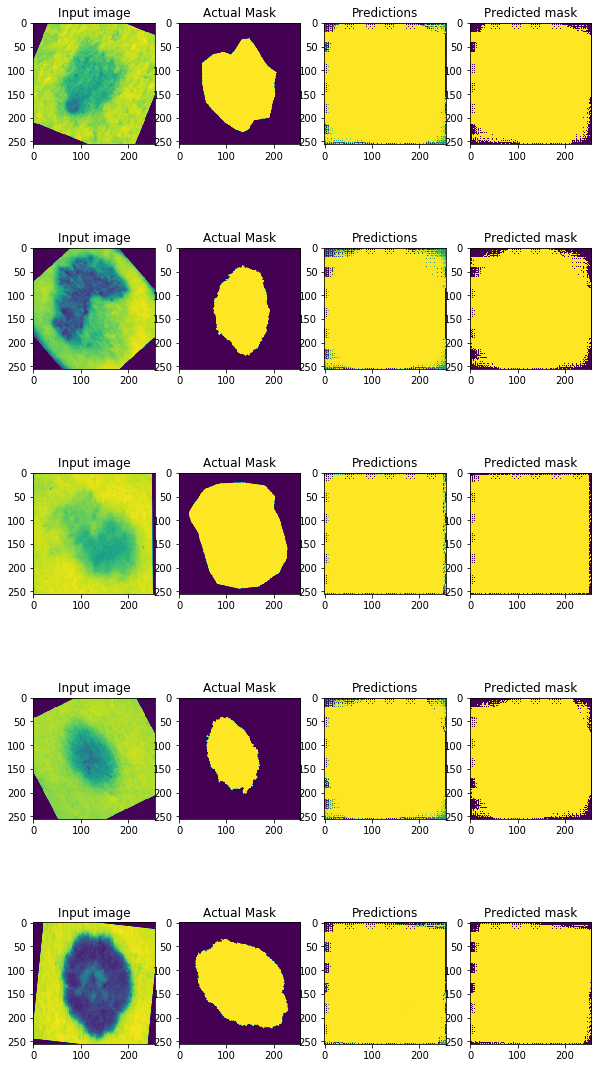

In [25]:
# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    img = test_imgs[i,:,:,0]
    label = test_masks[i,:,:,0]
    predicted_label = predictions[i,:,:,0]

    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(label)
    plt.title("Actual Mask")
    
    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(predicted_label)
    plt.title("Predictions")
    
    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow(predicted_label>0.99)
    plt.title("Predicted mask")
    
plt.show()